# Atividade 3 - Segmentação Semântica

### A) Densenvolva uma rede neural para segmentação semântica que seja capaz de segmentar algumas classes de interesse na cena apresentada como entrada do modelo. Para isso, crie um modelo similar à arquitetura da Rede U-net ou o da própria U-net se for de seu interesse, a fim de resolver o problema.
### B) O dataset utilizado para esta atividade será o CITYSCAPE DATASET: [link-cityscape](https://www.kaggle.com/dansbecker/cityscapes-image-pairs/download) (cique neste link para baixar no diretório principal de seu projeto)
### OBS1: Este dataset contém frames rotulados (segmentados) capturados a partir de veículos nas ruas da Alemanha.
### OBS2: Os comandos da atividade seguem com intruções a partir dos intens enumerados a seguir.

#### 1 - Seguem algumas bibliotecas que podem ser necessárias:

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7645045348710929143
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3131408277931824664
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1436136243
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4112834222232548139
physical_device_desc: "device: 0, name: GeForce GTX 750, pci bus id: 0000:01:00.0, compute capability: 5.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15764098162741973155
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.cluster import KMeans
import random
from joblib import dump, load

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D, concatenate
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

#### 2 - Após ter baixado o dataset apresentado no item B) no mesmo diretório deste jupyter notebook, extraia o 'archive.zip' e abaixo temos os path's para as imagens de treino e validação.

In [3]:
train_path='cityscapes_data/train'
val_path='cityscapes_data/val'

#### 3 - As imagens do dataset vieram da seguinte forma:

![](./imagens/exemplo_dado.jpg)

#### OBS: Ou seja, apresenta a imagem de entrada concatenada com a versão da imagem esperada (segmentada)!

#### 4 - [Implemente]: Complete a função seguinte (_load_image_pair_), de modo que ela seja capaz de ler a imagem como um numpy array no formato RGB, seja usando opencv ou Pillow e que retorne separadas as imagens de entrada e segmentada.

In [4]:
 def load_image_pair(file_name,
                    path=train_path,
                    rotation=0.0,
                    flip=False,
                    size=(256, 256)):
    
    # Path da imagem do dataset de treino ou validação. 
    # Por default o parâmetro está pegando o path de treino.
    image_path = os.path.join(path, file_name)
    
    # Neste bloco leia a Imagem neste bloco como RGB numpy array.
    imgs_concat = cv2.imread(image_path)
    imgs_concat = cv2.cvtColor(imgs_concat, cv2.COLOR_BGR2RGB)
    
    # Neste bloco separe imagem de entrada e imagem segmentada.
    seg = imgs_concat[:,256:]
    img = imgs_concat[:,:256]
    
    #Este boco irar equalizar os canais RGB da imagem - Já implementado
    for i in range(3):
        zimg = img[:,:,i]
        zimg = cv2.equalizeHist(zimg)
        img[:,:,i] = zimg
        
    list_images = [img, seg]
    
    # Neste bloco dê um resize nas duas imagens para o size passado como paâmetro na função.
    # Esse será o tamanho da entrada da nossa rede neural.
#     for i in range(len(list_images)):
#         list_images[i] = cv2.resize(list_images[i], size, interpolation=cv2.INTER_CUBIC)
    
    # Neste bloco aplique uma rotação na imagem (isso será usado mais a frente emum generator).
    # Por default este parâmetro está com rotação de 0 graus, ou seja, não vai rotacionar a princípio.
    if rotation != 0.0:
        for i in range(len(list_images)):
            image_center = tuple(np.array(list_images[i].shape[1::-1]) / 2)
            rot_mat = cv2.getRotationMatrix2D(image_center, rotation, 1.0)
            list_images[i] = cv2.warpAffine(list_images[i], rot_mat, list_images[i].shape[1::-1], flags=cv2.INTER_CUBIC)
   
    # Neste bloco as duas imagens sofrem um flip horizontal. Por default está False. Ou seja, não vai flippar,
    # a menos que peçamos para tal. Servirar par ao genrator mais a frente.
    if flip:
        for i in range(len(list_images)):
            list_images[i] = list_images[i][:,::-1,:]
    
    return list_images[0]/255, list_images[1]/255 # Ao final já normaliza as duas imagens entre 0 e 1!

In [5]:
img, seg = load_image_pair("10.jpg")

In [6]:
def compare(img1, img2, size, title):
    fig = plt.figure(figsize=(size*2,size))
    fig.suptitle(title, fontsize=30)
    ax1 = plt.subplot(121)
    plt.title(str(img1.shape))
    plt.imshow(img1)
    ax2 = plt.subplot(122)
    plt.title(str(img2.shape))
    plt.imshow(img2)
    plt.show()

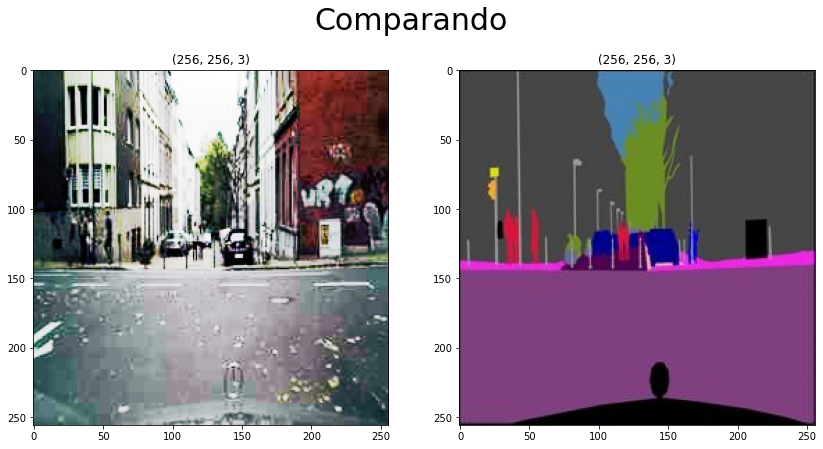

In [7]:
compare(img, seg, 7, "Comparando")

#### 5 - [Implemente]: Agora vamos treinar o KMEANS para separar as cores das imagens segmentadas com K=13 categorias. Isso servirá para gerar o mapa de labels dos pixels.

##### 5.1 - Vetorize as imagens RGB versão segmentada do conjunto de treinamento e armazene todas em uma lista _colors_: Por exempo, se as imagens estão com o shape (256, 200, 3) devem se tornar com o shape (256*200, 3) - [ou seja, os três canais RGB devem ficar intactos]:
##### OBS: Use a função load_image_pair para carregar as imagens com os parâmetros de data augmentation default.

In [8]:
colors = []

for file in os.listdir(train_path):
    _, seg = load_image_pair(file)
    colors.append(np.reshape(seg, (-1, 3)))

In [9]:
test_colors = np.reshape(colors[2], (256, 256, 3))

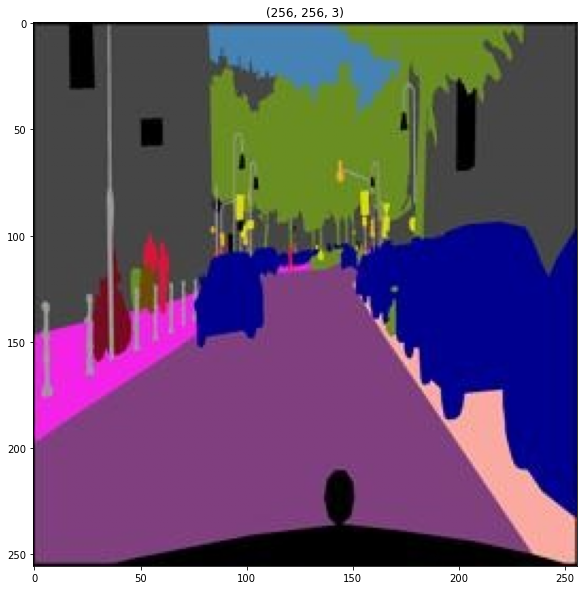

In [10]:
def plot(img, size):
    plt.figure(figsize=(size,size))
    plt.imshow(img)
    plt.title(str(img.shape))
    plt.show()
    
plot(test_colors, 10)

##### 5.2 - Vamos transformar a lista de arrays RGB em um grande array usando a função np.array():

In [11]:
colors_array = np.array(colors[:550]) # Só 550 imagens da base train - são 2975 no total

In [12]:
colors_array.shape

(550, 65536, 3)

##### 5.3 - Vamos transformar o ARRAY  de todas as imagens RGB de treino em uma grande matriz de pixels RGB: Por exemplo. Aqui o array será algo com o shape (número de  imagens, 256 * 200, 3), vamos dar um reshape e torná-la (número de  imagens * 256 * 200, 3) e Aplicar o Kmeas de K=13 nela para seguimentar as tuplas RGB.

In [13]:
rgb_arr = np.reshape(colors_array, (-1, 3))

In [14]:
rgb_arr.shape

(36044800, 3)

In [15]:
K = n_colors = 13

# km = KMeans(K).fit(rgb_arr)

In [16]:
# dump(km, 'km.joblib')

In [17]:
km = load('km.joblib')

In [18]:
test_k = np.reshape(km.labels_, (550, -1)) # Só 550 imagens da base train - são 2975 no total

####  6 - [Implemente]: Implementar a função que irá receber a imagem versão segmentada e gerar a partir dela o tensor (conjunto de mapas de features -  como o da figura abaixo) usando o Kmeans que foi treinado para rotular os pixels de cada categoria:

<img src="./imagens/19.png" alt="drawing" width="800"/>

In [19]:
seg_k = np.reshape(test_k[300], (256, -1))

In [20]:
channel_1 = np.where(seg_k == 1, 1, 0)

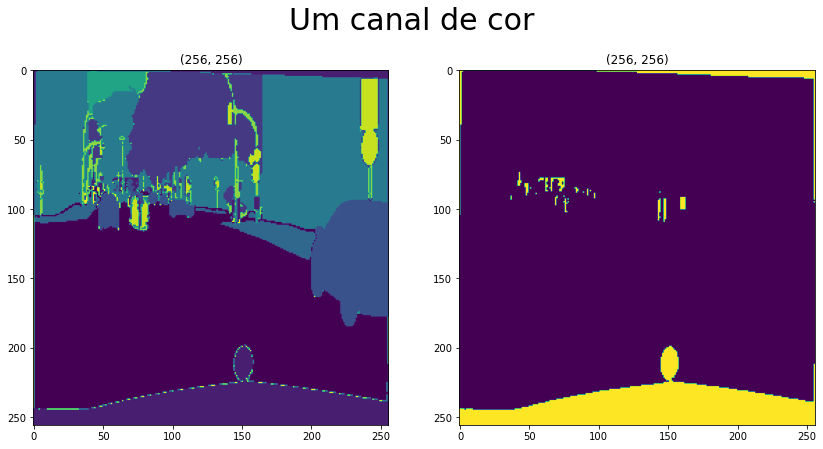

In [21]:
compare(seg_k, channel_1, 7, "Um canal de cor")

In [22]:
def colors_to_class_layers(seg):
    
    # Deixa imagem no formato necessário para passar no Kmeans -- já codificado
    s = seg.reshape((-1, 3))
    
    # Passa no Kmenas treinado -- já codificado
    s = km.predict(s)
    
    # Pega a imagem gerada pelo agrupamento do Kmeans no format linhas x colunas  --- já codificado
    s = s.reshape((seg.shape[:2]))
    
    # Pega número de clusters e cria um array-tensor com o número de mapas com a quantidade de 
    # classes (clusters) -- já codificado
    classes = np.zeros((seg.shape[0], seg.shape[1], n_colors))
    
    # Neste bloco, implemente um for sobre as classes (clusters), crie uma cópia de s e verifique 
    # quais pixels dele tem valor igual ao índice que representa a classe da vez. Quando for igual 
    # atribua o valor 1 a exste pixel e quando não atribua zero. Assim teremso mapas para as classes 
    # sendo imagens binárias (com zeros e uns). Depoois preencha os n mapas no array classes e retorne ele.
    
    for i in range(n_colors):
        this_color = np.where(s == i, 1, 0)
        classes[:,:,i] = this_color
       
    return classes

#### 7 - Abaixo, segue já implementada uma função para converter a imagem segmentada no formato de layers para uma imagem RGB para ser apresentada.

In [23]:
def layers_to_rgb_image(layers):
    
    # Lista de tuplas RGB para representar as cores das regiões segmentadas. 
    # 13 cores e mais o preto para quando não for nenhuma das classes de interesse
    colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0), (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    # Imagem de saída.
    img_out = np.zeros((layers.shape[0], layers.shape[1], 3))
    
    for i in range(layers.shape[2]): # Percorre as n layers, no caso aqui 13 classes
        
        c = layers[:,:,i] # Pega a layer da vez
        col = colors[i] # Pega uma cor pra essa layer/classe
        
        for j in range(3): # percorre os canais RGB
            img_out[:,:,j] += col[j]*c # Pega a layer binária e multiplica pela cor que ela deverá ter
            
    img_out = img_out/255.0 # Normaliza imagem resultante entre 0 e 1 e, em seguida retorna
    
    return img_out

#### 8 - [Implemente]: Abaixo, segue um generator que será usado para o treinamento. Por default, já está o path dos dados de treinamento, mas tambem poderá ser usada para os dados de validação também.

In [24]:
def Generate(path=train_path,
             batch_size=1,
             maxangle=10.0):
    
    # Maxangle é o angulo máximo que a imagem pode ser rotacionada. Por default é 10.
    
    image_files = os.listdir(path)
    
    while True:
        
        # Listas para imagem e versão segmentada
        imgs=[]
        segs_layers=[]
        
        for i in range(batch_size):# For para geração do batch/lote
            
            file = random.sample(image_files, 1)[0] # Sorteia um arquivo entre todos.
            
            # Neste bloco, implemente uma forma de aleatoriamente a imagem da vez ser flippada 
            # na Horizontal ou não, bem como sortear um angulo para rotacionar entre -maxangle e maxangle
            # que, por default, é 10 e pode manter esse angulo máximo para a atividade.
            
            angle = random.uniform(-maxangle, maxangle)
            flip = random.choice([True, False])
            
            # Usa a função load_image_pair implementada lá em cima
            # recebe o arquivo da vez, o path de treinamento ou validação, o angulo
            # para rotacionar e a flag flip para flippar na horizontal ou não.
            img, seg = load_image_pair(file, path, rotation=angle, flip=flip)
            
            # Retora o mapa de layers da imagem segmentada
            seg_layers = colors_to_class_layers(seg)
            
            imgs.append(img)
            segs_layers.append(seg_layers)
            
            
        # Retorna (yield) imagens com augmentation ou não, bem como sua versão segmentada no formato de layers
        yield np.array(imgs), np.array(segs_layers) 

#### 9 - [Implemente]: Crie aqui o modelo U-net ou inspirado na arquitetura dele! A parte condificadora já está pré-codificada e o início da parte Decodificadora também está. Complete.

In [25]:
input_layer = Input(shape=(256, 256, 3))

x1 = BatchNormalization()(input_layer)
x1 = Conv2D(64, 12, activation="relu", padding="same")(x1)
x1 = Conv2D(128, 12, activation="relu", padding="same")(x1)
p1 = MaxPooling2D()(x1)


x2 = Conv2D(128, 9, activation="relu", padding="same")(p1)
x2 = Conv2D(128, 9, activation="relu", padding="same")(x2)
p2 = MaxPooling2D()(x2)


x3 = Conv2D(128, 6, activation="relu", padding="same")(p2)
x3 = Conv2D(128, 6, activation="relu", padding="same")(x3)
p3 = MaxPooling2D()(x3)


x4 = Conv2D(128, 3, activation="relu", padding="same")(p3)
x4 = Conv2D(128, 3, activation="relu", padding="same")(x4)


x5 = UpSampling2D()(x4)
x5 = concatenate([x3, x5])
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)


x6 = UpSampling2D()(x5)
x6 = concatenate([x2, x6])
x6 = Conv2D(128, 9, activation="relu", padding="same")(x6)
x6 = Conv2D(128, 9, activation="relu", padding="same")(x6)

x7 = UpSampling2D()(x6)
x7 = concatenate([x1, x7])
x7 = Conv2D(128, 12, activation="relu", padding="same")(x7)
x7 = Conv2D(64, 12, activation="relu", padding="same")(x7)

x7 = Conv2D(13, (1,1), activation="softmax")(x7)


model = Model(input_layer, x7)

optmizer = Adam(lr=0.0001)
model.compile(optimizer=optmizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 27712       batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 128 1179776     conv2d[0][0]                     
______________________________________________________________________________________________

#### 10 - [Implemente]: Instancie os generator de treino e validação (já está ocdificado) e treine o modelo usando o fit_generator do keras:
#### OBS: Use o callback que está abaixo no treinamento.
#### DICA: vai precisar de pelo menos umas 100 épocas para ter um resultado razoável. Usem o COLAB!

In [27]:
train_gen = Generate(train_path)
val_gen = Generate(val_path)

In [28]:
callback_list = [ModelCheckpoint("model_best.h5", save_best_only=True, verbose=0)]

In [29]:
history = model.fit(train_gen,
                    epochs=200,
                    steps_per_epoch=5,
                    validation_data=val_gen,
                    validation_steps=5,
                    callbacks=callback_list)

Epoch 1/200
5/5 [==============================] - 22s 4s/step - loss: 2.3980 - accuracy: 0.2149 - val_loss: 2.3575 - val_accuracy: 0.1904
Epoch 2/200
5/5 [==============================] - 22s 4s/step - loss: 2.2200 - accuracy: 0.2756 - val_loss: 2.1961 - val_accuracy: 0.3506
Epoch 3/200
5/5 [==============================] - 21s 4s/step - loss: 2.4887 - accuracy: 0.1973 - val_loss: 2.1914 - val_accuracy: 0.3416
Epoch 4/200
5/5 [==============================] - 20s 4s/step - loss: 2.0638 - accuracy: 0.3193 - val_loss: 2.2401 - val_accuracy: 0.3955
Epoch 5/200
5/5 [==============================] - 21s 4s/step - loss: 2.2275 - accuracy: 0.3309 - val_loss: 2.2413 - val_accuracy: 0.2669
Epoch 6/200
5/5 [==============================] - 21s 4s/step - loss: 2.1058 - accuracy: 0.2670 - val_loss: 2.1090 - val_accuracy: 0.3143
Epoch 7/200
5/5 [==============================] - 21s 4s/step - loss: 2.2437 - accuracy: 0.2434 - val_loss: 2.1592 - val_accuracy: 0.1538
Epoch 8/200
5/5 [==========

5/5 [==============================] - 22s 4s/step - loss: 1.4422 - accuracy: 0.5213 - val_loss: 1.2936 - val_accuracy: 0.6037
Epoch 60/200
5/5 [==============================] - 21s 4s/step - loss: 1.4491 - accuracy: 0.5613 - val_loss: 1.7266 - val_accuracy: 0.4509
Epoch 61/200
5/5 [==============================] - 22s 4s/step - loss: 1.1998 - accuracy: 0.6119 - val_loss: 1.2120 - val_accuracy: 0.6596
Epoch 62/200
5/5 [==============================] - 20s 4s/step - loss: 1.3657 - accuracy: 0.5977 - val_loss: 1.2812 - val_accuracy: 0.5949
Epoch 63/200
5/5 [==============================] - 20s 4s/step - loss: 1.2841 - accuracy: 0.6247 - val_loss: 1.2553 - val_accuracy: 0.5782
Epoch 64/200
5/5 [==============================] - 21s 4s/step - loss: 1.2957 - accuracy: 0.6154 - val_loss: 1.3087 - val_accuracy: 0.5931
Epoch 65/200
5/5 [==============================] - 21s 4s/step - loss: 1.1199 - accuracy: 0.6542 - val_loss: 1.2777 - val_accuracy: 0.5769
Epoch 66/200
5/5 [===============

5/5 [==============================] - 23s 5s/step - loss: 1.1030 - accuracy: 0.6129 - val_loss: 1.1228 - val_accuracy: 0.6554
Epoch 118/200
5/5 [==============================] - 22s 4s/step - loss: 1.3686 - accuracy: 0.5896 - val_loss: 1.2934 - val_accuracy: 0.6022
Epoch 119/200
5/5 [==============================] - 21s 4s/step - loss: 1.1569 - accuracy: 0.6338 - val_loss: 1.3456 - val_accuracy: 0.6210
Epoch 120/200
5/5 [==============================] - 22s 4s/step - loss: 1.2275 - accuracy: 0.6086 - val_loss: 1.1107 - val_accuracy: 0.6546
Epoch 121/200
5/5 [==============================] - 22s 4s/step - loss: 1.2718 - accuracy: 0.5937 - val_loss: 1.2019 - val_accuracy: 0.5861
Epoch 122/200
5/5 [==============================] - 22s 4s/step - loss: 0.9525 - accuracy: 0.6860 - val_loss: 1.2483 - val_accuracy: 0.6103
Epoch 123/200
5/5 [==============================] - 23s 5s/step - loss: 1.1447 - accuracy: 0.6406 - val_loss: 0.9314 - val_accuracy: 0.6958
Epoch 124/200
5/5 [========

5/5 [==============================] - 20s 4s/step - loss: 0.9635 - accuracy: 0.6891 - val_loss: 1.5092 - val_accuracy: 0.6154
Epoch 176/200
5/5 [==============================] - 20s 4s/step - loss: 1.1668 - accuracy: 0.6645 - val_loss: 1.3972 - val_accuracy: 0.5722
Epoch 177/200
5/5 [==============================] - 20s 4s/step - loss: 1.0728 - accuracy: 0.6806 - val_loss: 1.0119 - val_accuracy: 0.6669
Epoch 178/200
5/5 [==============================] - 22s 4s/step - loss: 1.0038 - accuracy: 0.6535 - val_loss: 0.8785 - val_accuracy: 0.7170
Epoch 179/200
5/5 [==============================] - 19s 4s/step - loss: 1.0833 - accuracy: 0.6656 - val_loss: 0.9921 - val_accuracy: 0.6650
Epoch 180/200
5/5 [==============================] - 21s 4s/step - loss: 0.9462 - accuracy: 0.6990 - val_loss: 1.3866 - val_accuracy: 0.6318
Epoch 181/200
5/5 [==============================] - 21s 4s/step - loss: 1.0888 - accuracy: 0.6507 - val_loss: 0.9489 - val_accuracy: 0.6878
Epoch 182/200
5/5 [========

In [30]:
# model.save('cuda_try.h5')

In [31]:
# loaded_model = load_model('cuda_try.h5')

# loaded_model.evaluate(val_gen)

#### 11 - [Implemente]: Plote as curvas de treinamento loss e accuracy de treino e validação:

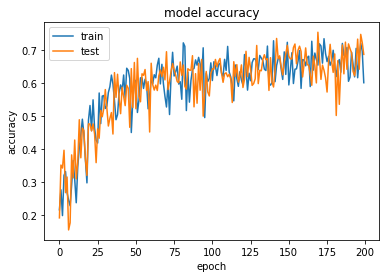

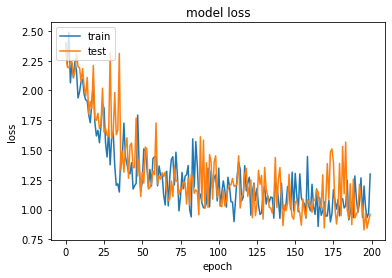

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 12 - [Implemente]: Plote para pelo menos 20 imagens do conjunto de validação após passar no modelo treinado sua versào segmentada esperada (label) e a imagem obtida! Use as funções implementadas lá em cima que forem necessárias para as conversões.
#### OBS: Algo parecido com a imagem abaixo.

![](./imagens/example-out.png)

#### %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

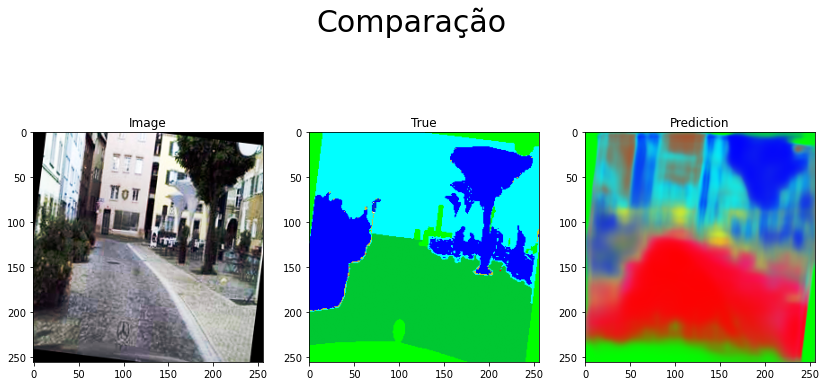

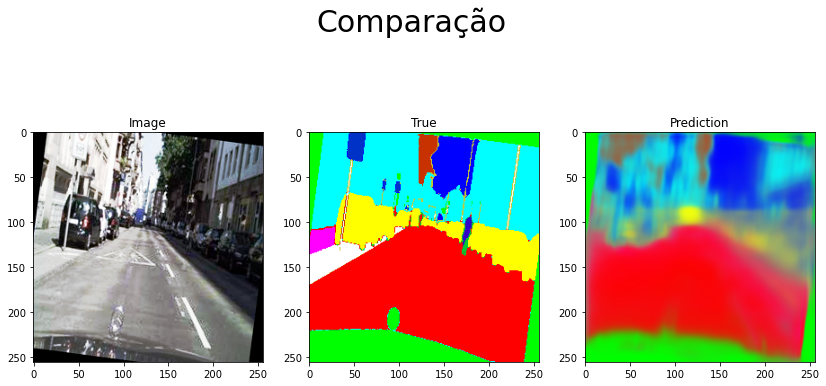

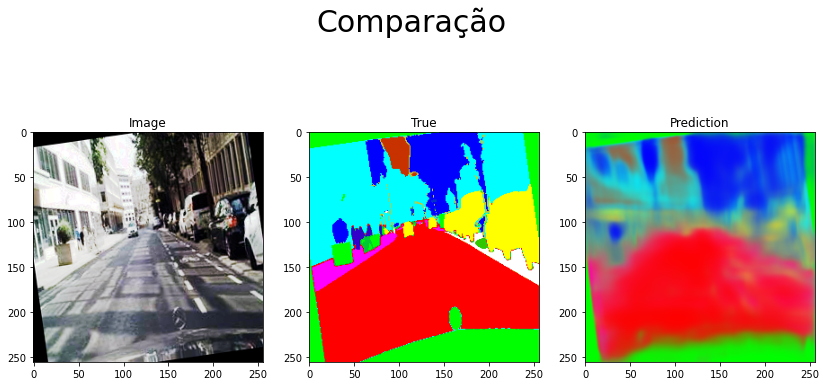

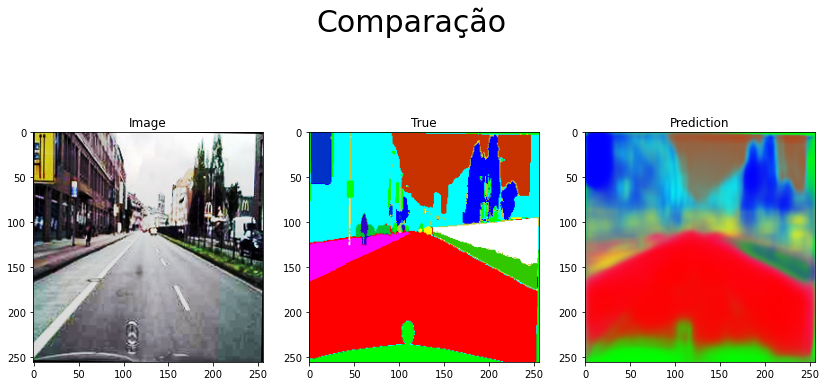

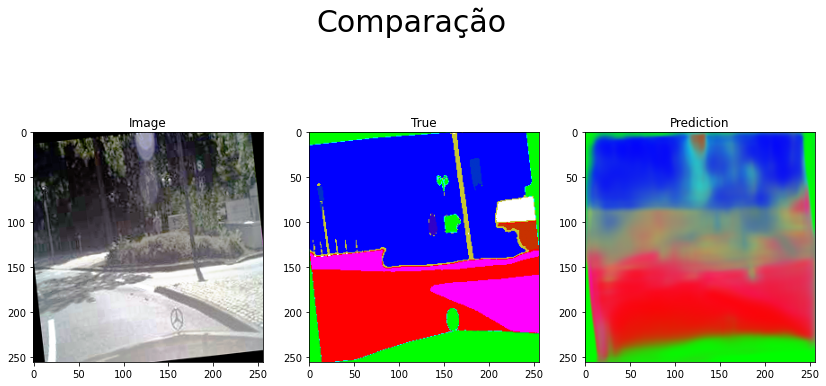

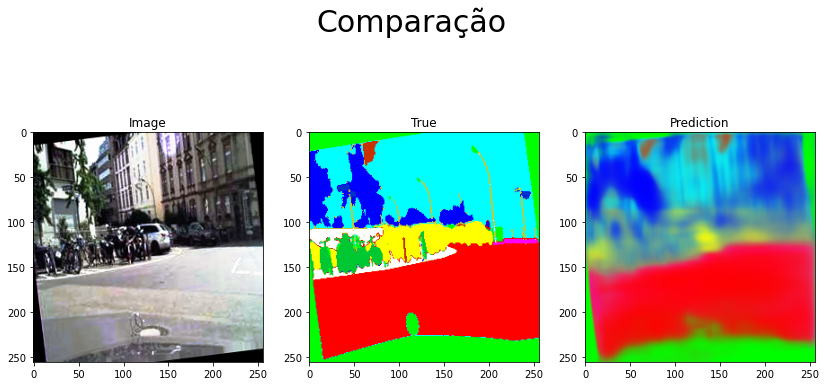

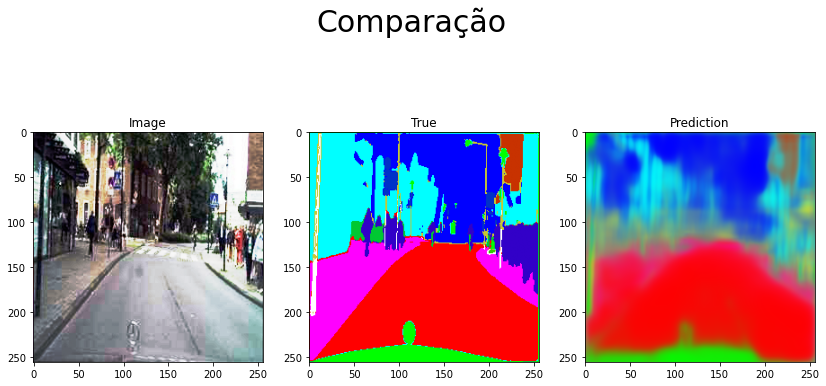

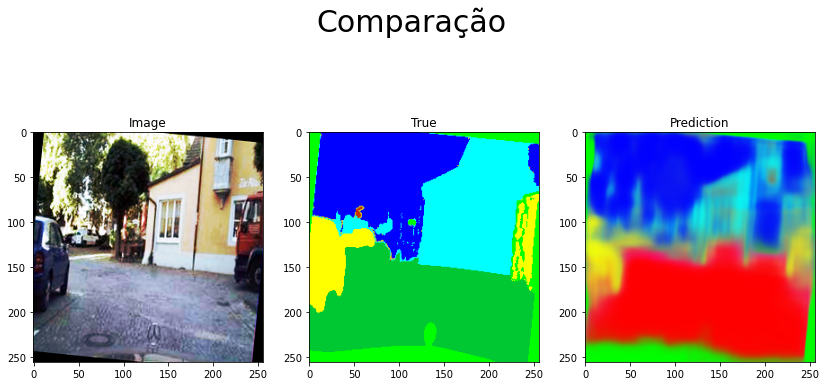

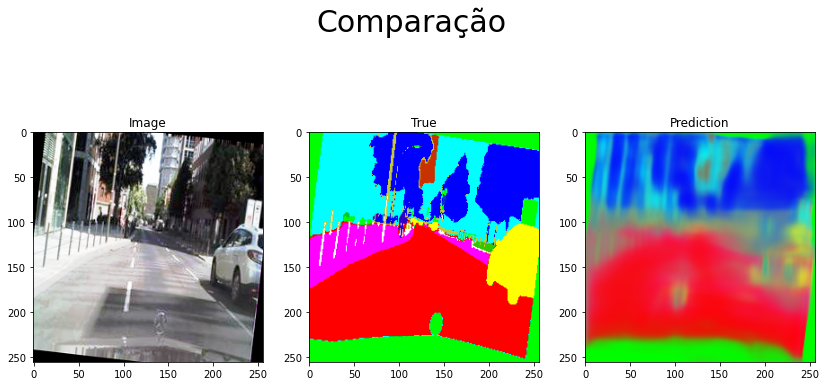

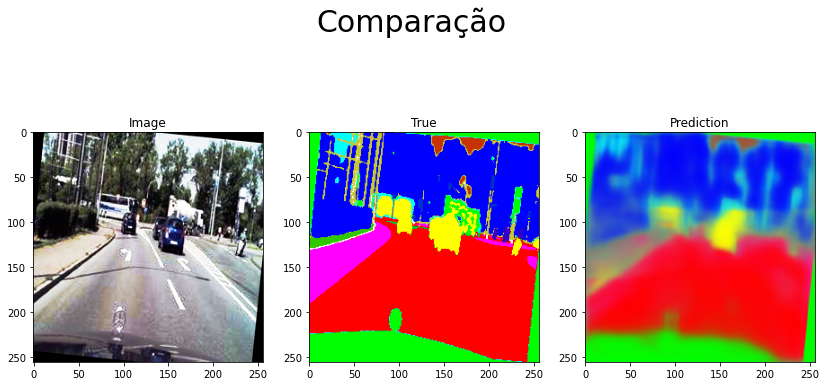

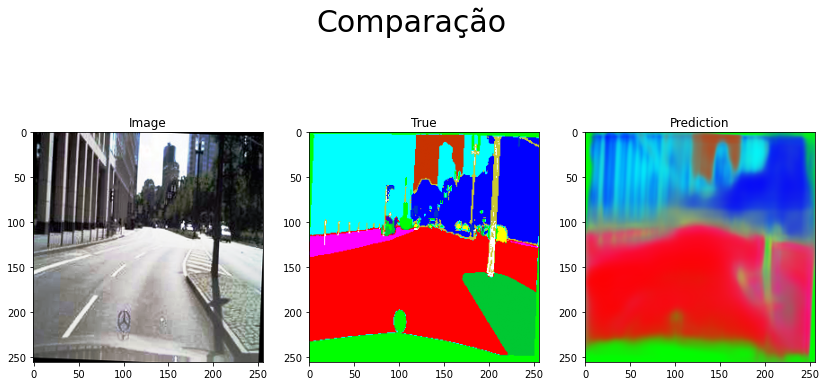

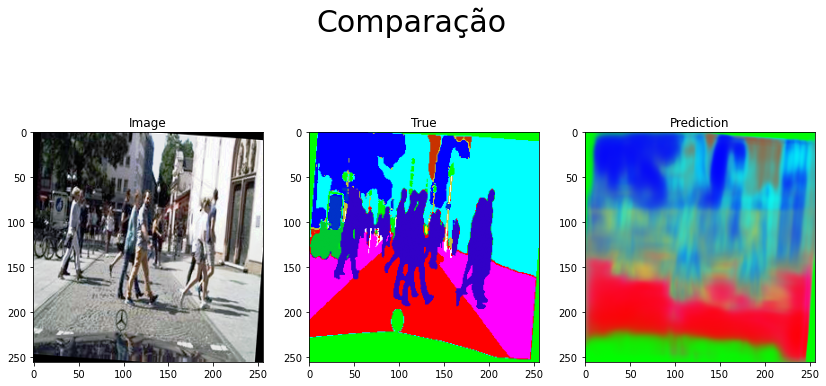

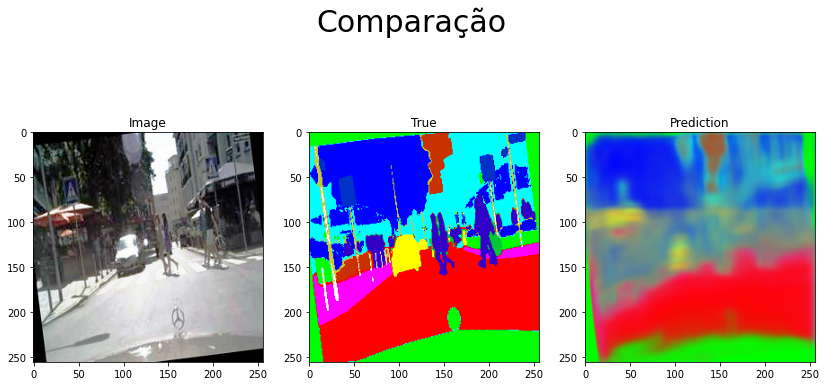

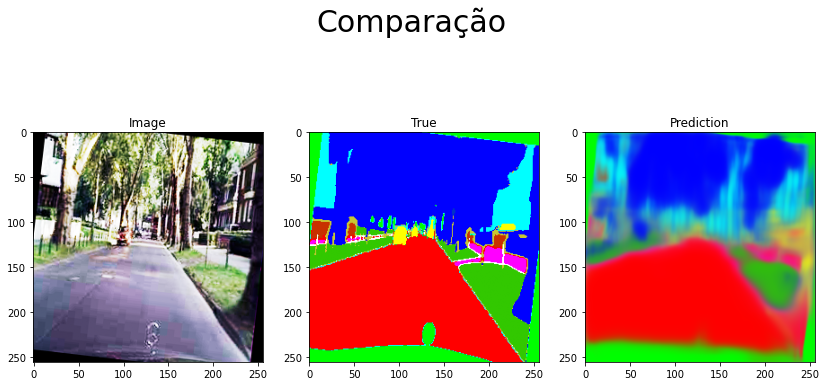

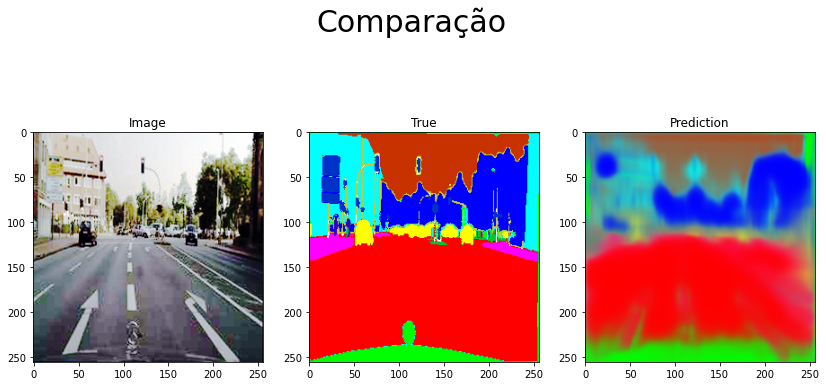

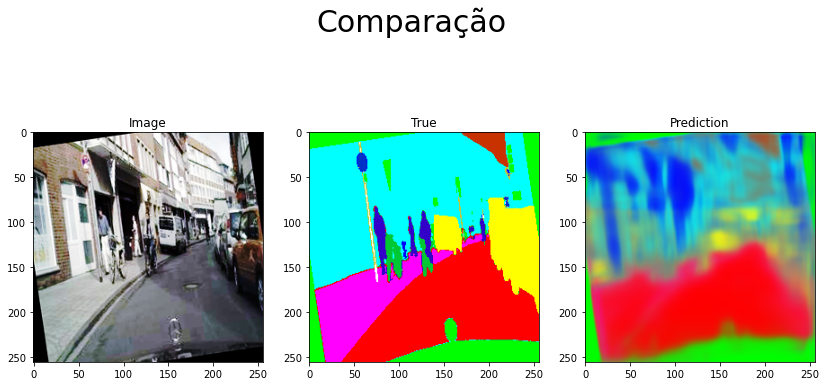

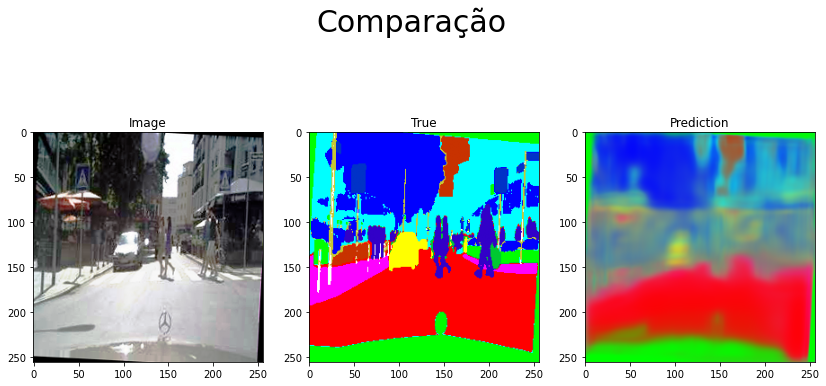

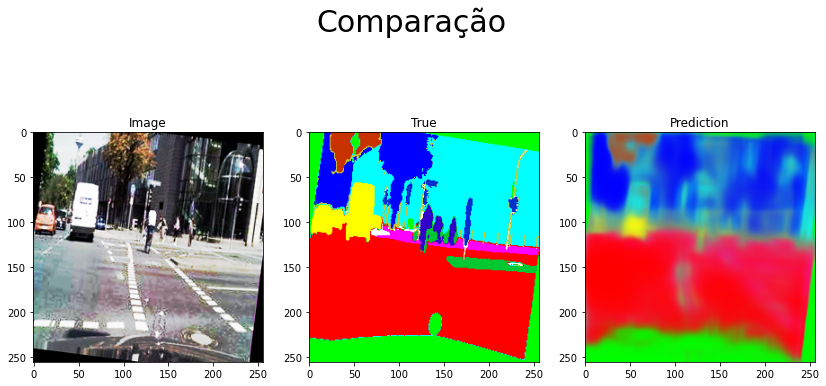

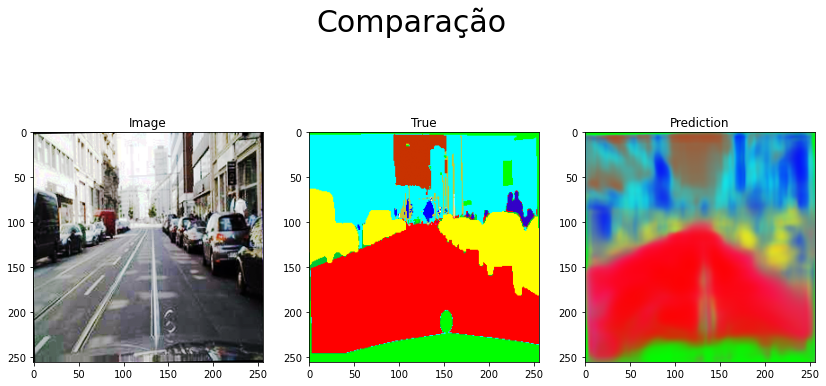

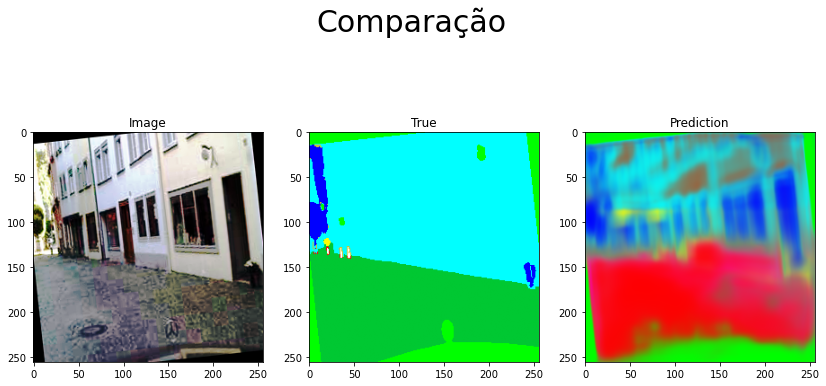

In [ ]:
test_gen = Generate(val_path)

def plot_three(img1, img2, img3, size, title):
    fig = plt.figure(figsize=(size*2,size))
    fig.suptitle(title, fontsize=30)
    ax1 = plt.subplot(131)
    plt.title("Image")
    plt.imshow(img1)
    ax2 = plt.subplot(132)
    plt.title("True")
    plt.imshow(img2)
    ax3 = plt.subplot(133)
    plt.title("Prediction")
    plt.imshow(img3)
    plt.show()

i = 0
for imgs, segs in test_gen:
    while i < 20:
        imgs, segs = next(test_gen)
        pred = model.predict(imgs)
        pred = layers_to_rgb_image(np.reshape(pred, (256, 256, 13)))
        plot_three(np.reshape(imgs, (256, 256, 3)), layers_to_rgb_image(np.reshape(segs, (256, 256, 13))), pred, 7, "Comparação")
        next(test_gen)
        i += 1

### FIM